In [2]:
import collections
import math
import os
import random
import zipfile
import numpy as np
import urllib
import tensorflow as tf

/home/hhl/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
url = 'http://mattmahoney.net/dc/'
def maybe_download(filename, expected_bytes):
    if not os.path.exists(filename):
        filename,_ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename
filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [17]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        obj = f.read(f.namelist()[0])
        data = tf.compat.as_str(obj).split() # tf.compat.as_str 将数据转成单词列表
    return obj,data

obj,words = read_data(filename)
print('Data Size', len(words))

Data Size 17005207


In [20]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1)) # 统计词频，将top 50000的词放入count
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary) # len(dictionary) 单词的排序，编号
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary: # 在词典中则编号， 不在词典中编号为0
            index = dictionary[word]
        else:
            index = 0
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)

In [21]:
del words
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


skip-Gram 模式（从目标单词反推语境）

'the quick brown fox jumped over th lazy dog' 转为(quick，the)(quick，brown)(brown，quick) (broown, fox)

skip_window:指最远可以联系的距离，1代表紧邻的单词。
num_skips：为每个单词生产多少个样本，不能大于skip_window的两倍，并且是batch_size的整数倍，(确保每个batch包含一个词汇的对应的所有样本）
span:对某个单词创建相关样本时会使用到的单词数量

In [30]:
data_index = 0 
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0 
    assert num_skips <= 2*skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2*skip_window + 1
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips): # 给batch_size // num_skips个target单词，每个单词产生num_skips个context
        target = skip_window
        target_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in target_to_avoid:
                target = random.randint(0, span - 1)
            target_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window] 
            labels[i * num_skips +j, 0] = buffer[target]
        buffer.append(data[data_index]) # 找完一个词buffer 往前滑动一格
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [31]:
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i],reverse_dictionary[batch[i]],'->',labels[i,0],reverse_dictionary[labels[i,0]])

3081 originated -> 12 as
3081 originated -> 5234 anarchism
12 as -> 6 a
12 as -> 3081 originated
6 a -> 195 term
6 a -> 12 as
195 term -> 2 of
195 term -> 6 a


In [36]:
batch_size = 128
embedding_size = 128
skip_window = 1
num_skips = 2

valid_size = 16
valid_window = 100
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64

In [37]:
valid_examples

array([42, 71, 19,  9, 70, 89, 36,  5, 72, 51, 85, 14, 69, 53, 76,  4])

In [28]:
graph = tf.Graph()
with graph.as_default():
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_example, dtype=tf.int32)
    with tf.device('/cpu:0'):
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings,train_inputs)
        nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0/math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights, # [vocab_size, embed_size]
                                         biases=nce_biases,# [embed_size]
                                         labels=train_labels,# [bs, 1]
                                         inputs=embed, # [bs, embed_size]
                                         num_sampled=num_sampled, 
                                         num_classes=vocabulary_size))
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
    init = tf.global_variables_initializer()

In [38]:
num_steps = 10001
with tf.Session(graph=graph) as session:
    init.run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips,skip_window)
        feed_dict = {train_inputs:batch_inputs,train_labels:batch_labels}
        _,loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        if step % 2000 == 0:
          if step > 0:
            average_loss /= 2000
          # The average loss is an estimate of the loss over the last 2000 batches.
          print("Average loss at step ", step, ": ", average_loss)
          average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
          sim = similarity.eval()
          for i in range(valid_size):
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 8 # number of nearest neighbors
            nearest = (-sim[i, :]).argsort()[1:top_k+1]
            log_str = "Nearest to %s:" % valid_word
            for k in range(top_k):
              close_word = reverse_dictionary[nearest[k]]
              log_str = "%s %s," % (log_str, close_word)
            print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  283.4420166015625
Nearest to but: ukiyo, dakar, vikrant, polyurethane, peninsula, toolbox, rudder, empresses,
Nearest to world: institute, universidad, crystal, cuyp, grab, formations, amanullah, bursa,
Nearest to by: sniper, luftwaffe, dempsey, supposition, ton, argyll, worst, morrill,
Nearest to nine: banana, unspecified, necessitated, redactor, archaeopteryx, galloway, catharism, bibles,
Nearest to than: tectonics, legislature, apcs, intergovernmental, shunned, foldoc, earp, visiting,
Nearest to called: wyclif, colliding, transposed, hydride, shore, electrochemical, pulsed, bike,
Nearest to he: longstanding, malignant, berliner, nster, michelson, corning, triplets, overheat,
Nearest to in: wailing, cargo, jason, salah, aw, perfective, entertainments, visionaries,
Nearest to i: programming, conf, mechanics, nautilus, sultan, pandavas, knitted, torvalds,
Nearest to more: bondage, inquirer, baka, taichi, emphasised, erudite, adar, snare,
Nearest t

In [13]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))  #in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)

In [14]:
try:
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
  plot_only = 200
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
  labels = [reverse_dictionary[i] for i in range(plot_only)]
  plot_with_labels(low_dim_embs, labels)

except ImportError:
  print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")

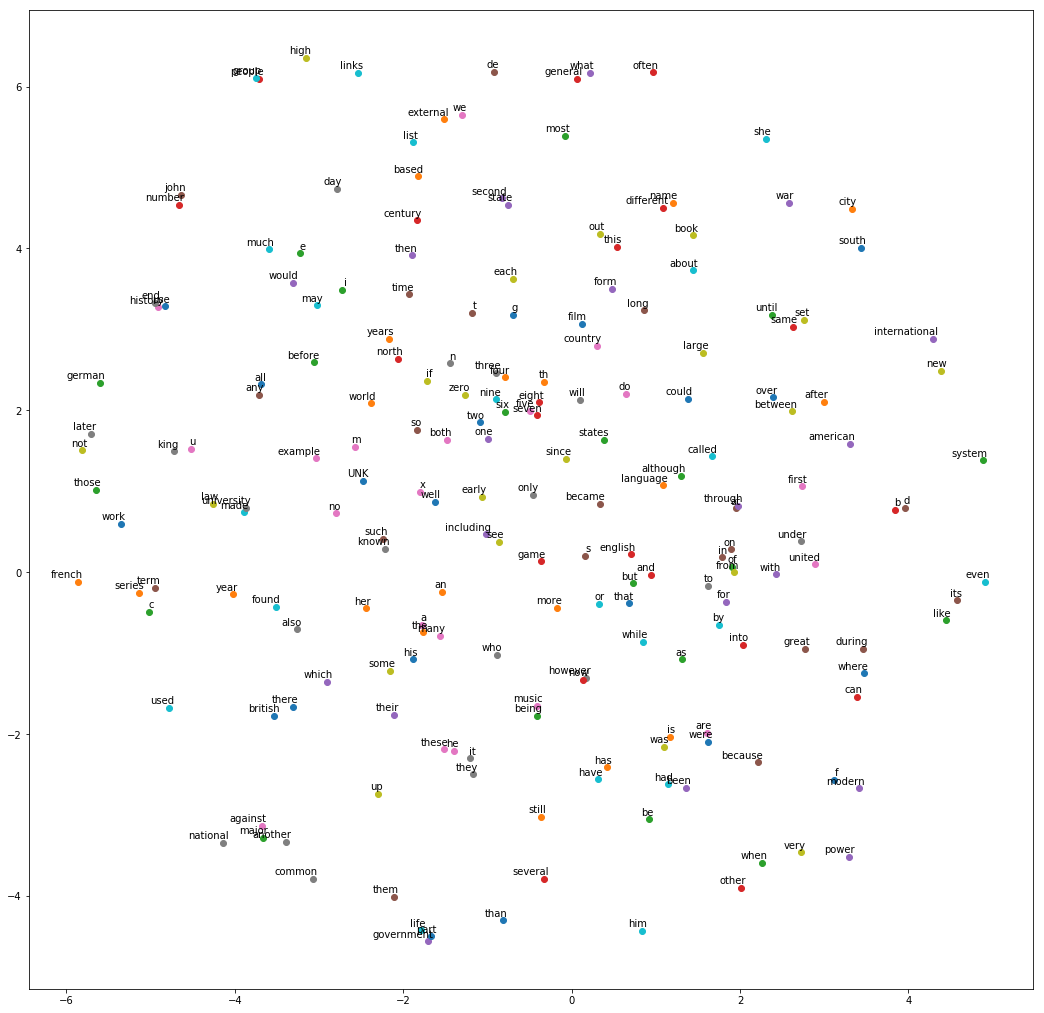

In [16]:
plt.show()

In [22]:
final_embeddings.shape

(50000, 128)